<a href="https://colab.research.google.com/github/mytangnyc/Enron_Analysis/blob/main/Initial_Email_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import numpy as np
from dateutil import parser
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pickle

import networkx as nx
import seaborn as sns

host = 'http://18.188.56.207:9200/'
requests.get(host + '_cat/indices/enron').content

b'yellow open enron fknPAAZdSL6-SjWpBvfASw 1 1 251734 0 539.9mb 539.9mb\n'

In [ ]:
def elasticsearch_results_to_df(results):
    '''
    A function that will take the results of a requests.get 
    call to Elasticsearch and return a pandas.DataFrame object 
    with the results 
    '''
    hits = results.json()['hits']['hits']
    data = pd.DataFrame([i['_source'] for i in hits], index = [i['_id'] for i in hits])
    data['date'] = data['date'].apply(parser.parse)
    return(data)

def print_df_row(row):
    '''
    A function that will take a row of the data frame and print it out
    '''
    print('____________________')
    print('RE: %s' % row.get('subject',''))
    print('At: %s' % row.get('date',''))
    print('From: %s' % row.get('sender',''))
    print('To: %s' % row.get('recipients',''))
    print('CC: %s' % row.get('cc',''))
    print('BCC: %s' % row.get('bcc',''))
    print('Body:\n%s' % row.get('text',''))
    print('____________________')

def pltgraph_interval(df):
    cwd = os.getcwd()
    filepath = os.path.join(cwd, "drive/MyDrive/Colab Notebooks/dataframes/prices_events.pickle")
    df_prices_events = pd.read_pickle(filepath)

    #Create combo chart
    fig, ax1 = plt.subplots(figsize=(10,6))
    color = 'tab:green'
    #bar plot creation
    ax1.set_title('Enron Price Over Time', fontsize=16)
    ax1.set_xlabel('Quarter', fontsize=16)
    ax1.set_ylabel('Price', fontsize=16)
    sns.lineplot(data=df_prices_events, x="Date", y="Close")
    sns.scatterplot(data=df_prices_events, x="Date", y="Close", hue='Event_Type', s=75, edgecolor='r',
                    linewidth=1)  # Baseline and markers on it.
    ax1.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
    ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")
    ax1.tick_params(axis='y')

    plt.axvline(x=df['date'].min())
    plt.axvline(x=df['date'].max())

    plt.show()

In [ ]:
doc = {
  "query": {
    "query_string": {
      "query":    "barge AND nigeria",
      "fields": [ "text"]
    }
  },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search',
               data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query, of " % r.json()['hits']['total'])
df = elasticsearch_results_to_df(r)
print("Returned %s messages" % df.shape[0])

Found {'value': 17, 'relation': 'eq'} messages matching the query, of 
Returned 17 messages


In [ ]:
#######Organize to determine connected Graph
data_to_merge = df[['sender', 'recipients', 'cc', 'bcc']].dropna(subset=['recipients']).drop_duplicates() # select columns, remove NaN
records = data_to_merge.to_records(index=True)

In [ ]:
def email_extract(x):
    extract = []
    for row in x:
        if len(row[2]) > 1:
            row[2] = row[2].strip().split()
            [extract.append((row[0], row[1], x)) for x in row[2]]            
        else:
            [extract.append((row[0], row[1], row[x])) for x in range(2, len(row))]
    return extract

#Extract all e-mail records and generate the list of nodes
all_mails = email_extract(records)
all_mails_df = pd.DataFrame.from_records(all_mails, columns=['orig_id', 'sender', 'recipient'])
all_mails_df = all_mails_df.dropna(subset=['recipient']).drop_duplicates()
all_address_lst = all_mails_df['sender'].values.tolist()
all_address_lst.extend(all_mails_df['recipient'].values.tolist())
all_address_lst = list(set(all_address_lst))
node_list = dict(zip(all_address_lst, range(len(all_address_lst))))

In [ ]:
#Generate nodes and edges to prep for plotting.
graph_df = all_mails_df
graph_df['edge_1'] = graph_df['sender'].apply(lambda x: node_list[x])
graph_df['edge_2'] = graph_df['recipient'].apply(lambda x: node_list[x])
graph_df['sender_short'] = graph_df['sender'].str.split("@")
graph_df['sender_short'] = graph_df['sender_short'].apply(lambda x: x[0])
graph_df['recipient_short'] = graph_df['recipient'].str.split("@")
graph_df['recipient_short'] = graph_df['recipient_short'].apply(lambda x: x[0])

In [ ]:
#Generate the node graphs to determine networks through ego graphs
G = nx.Graph()
G.clear()
G.add_nodes_from(nodes_for_adding=node_list)
G = nx.from_pandas_edgelist(df=graph_df, source='sender_short', target='recipient_short', edge_attr='orig_id')
node_and_degree = G.degree()
#(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
full_sorted = sorted(node_and_degree, key=lambda x: x[1])
(largest_hub, degree) = full_sorted[-4]

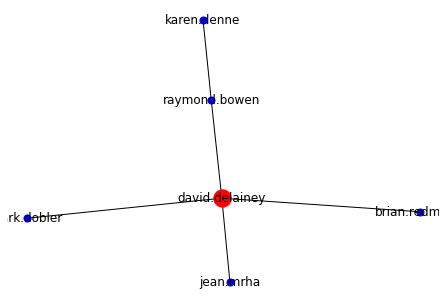

In [ ]:
hub_ego = nx.ego_graph(G, largest_hub, radius=2)

# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=True)
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
plt.show()

In [ ]:
doc = {
  "query": {
    "query_string": {
      "query":    "barge AND nigeria",
      "fields": [ "text"]
    }
  },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search',
               data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query, of " % r.json()['hits']['total'])
df = elasticsearch_results_to_df(r)
print("Returned %s messages" % df.shape[0])

Found {'value': 17, 'relation': 'eq'} messages matching the query, of 
Returned 17 messages


In [ ]:
doc = {
  "query": {
    "query_string": {
      "query":    "nigeria barge",
      "fields": [ "text"]
    }
  },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search',
               data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query, of " % r.json()['hits']['total'])
df = elasticsearch_results_to_df(r)
print("Returned %s messages" % df.shape[0])

Found {'value': 255, 'relation': 'eq'} messages matching the query, of 
Returned 255 messages


In [ ]:
excludes = ['Energy Issues', 'weekly report', 'Enron Mentions', 'Telecommunications Reports']
df_filtered = df[~df['subject'].str.contains('|'.join(excludes))]

In [ ]:
cwd = os.getcwd()
filepath = os.path.join(cwd, "../test.csv")
df_filtered.to_csv(filepath)

In [ ]:
doc = {
  "query": {
    "query_string": {
      "query":    "JEDI OR raptor OR LJM OR whitewing",
      "fields": [ "text"]
    }
  },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search',
               data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query, of " % r.json()['hits']['total'])
df = elasticsearch_results_to_df(r)
print("Returned %s messages" % df.shape[0])

Found {'value': 691, 'relation': 'eq'} messages matching the query, of 
Returned 691 messages


In [ ]:
# df[df.index =='170923']['text'].values #Acquired remaining interest in Barge (Full Sale)
# df[df.index =='195506']['text'].values #Demar Projected Cashflow
# df[df.index =='91418']['text'].values #Nigerian Barge as Support function for other roles?
# df[df.index =='135830']['text'].values #Cost basis on barges
# df[df.index =='203486']['text'].values #Interplay between Enron Nigeria Barge Ltd. and LJM2
# df[df.index =='203486']['text'].values #Interplay between Enron Nigeria Barge Ltd. and LJM2
# df[df.index =='143956']['text'].values #Demar Revenue Recognition
# df[df.index =='247178']['text'].values #Demar Revenue Recognition 2
# df[df.index =='52294']['text'].values #Possible Supply Manipulation to change Price? Holding Switching Demand?
# df[df.index =='67150']['text'].values #Difficulties justifying Methanold Plant valuation on balance sheet?
# df[df.index =='234402']['text'].values #JEDI Sale to related party
# df[df.index =='111079']['text'].values #LJM and Raptor valuations -- This is a pretty good one
# df[df.index =='226995']['text'].values #JEDI Investment Percentage
# df[df.index =='118002']['text'].values #Litigation holds.
# df[df.index =='118002']['text'].values #Litigation holds.
# df[df.index =='49600']['text'].values #Raptor Unwinds and loss consolidation onto balance sheet.
# df[df.index =='36575']['text'].values #"Owners" of movements into/out of SPVs. Also additional SPV names added below
# df[df.index =='148516']['text'].values #SPV Purchase agreements
# df[df.index =='50309']['text'].values #SEC 8K Report reflecting consolidation of SPVs onto balance sheet.
# df[df.index =='107846']['text'].values #Sale of Brigham to JEDI and ENA
# df[df.index =='230169']['text'].values #Description of SPV rules.
# df[df.index =='219158']['text'].values #Whitewing structure.
# df[df.index =='38742']['text'].values #Raptors seemed like a "cushion" for revenues for Enron
# df[df.index =='75294']['text'].values #Raptor Cushions lead to equity dilution? I don't quite understand this.
# df[df.index =='183824']['text'].values #TRS (Total Return Swaps)? Can we get attachments?

###Other structures worth investigating: LJM, Azurix, New Power Co., EBS, Chewco, Raptor, Whitewing, Marlin,
###Atlantic, Osprey, Braveheart, Yosemite, MEGS, Margaux, Backbone, Nahanni, Moose, Fishtail, Blackhawk,
###Portland General, Elektro, Cuiaba, Nowa Sarzyna, Dabhol, Dynergy, Rio Piedras, Merlin, Rawhide, Hawaii

In [ ]:
#Get Stock Prices and events list

In [ ]:
doc = {
  "query": {
    "query_string": {
      "query":    "barge AND nigeria",
      "fields": [ "text"]
    }
  },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search',
               data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query, of " % r.json()['hits']['total'])
df = elasticsearch_results_to_df(r)
print("Returned %s messages" % df.shape[0])

Found {'value': 17, 'relation': 'eq'} messages matching the query, of 
Returned 17 messages


In [ ]:
pltgraph_interval(df)

FileNotFoundError: ignored